## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, resample, find_peaks
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, cohen_kappa_score, matthews_corrcoef
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import os
import warnings
from tqdm import tqdm
import pickle

# Ignore warnings of a specific type (DeprecationWarning in this case)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")

## Support Vector Machine

In [60]:
# Read train_df and test_df
train_df = pd.read_csv('dataframes/train_df.csv')
test_df = pd.read_csv('dataframes/test_df.csv')

In [65]:
target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.fit_transform(test_df[target_column])

# Assign X_train and y_train from train_df
X_train = train_df[other_column_names]
y_train = train_df[target_column]

# Assign X_test and y_test from test_df
X_test = test_df[other_column_names]
y_test = test_df[target_column]

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'decision_function_shape': ['ovr', 'ovo']
}

# Create an SVM classifier
svm_classifier = SVC(random_state=100)

# Create a GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='recall_macro')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
pickle.dump(best_estimator, open('models/SVM.pickle', "wb"))

print("Best Parameters:", best_params)

# Make predictions on the test data using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate the recall, F1-score, Cohen's kappa and Matthews corrcoef of the classifier
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cohen_kappa = cohen_kappa_score(y_test, y_pred)
matthews = matthews_corrcoef(y_test, y_pred)

print(f"Recall: {recall*100:.1f}%")
print(f"F1: {f1*100:.1f}%")
print(f"Cohen's kappa score: {cohen_kappa:.3f}")
print(f"Matthews correlation coefficient: {matthews:.3f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Best Parameters: {'C': 100, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
Recall: 32.9%
F1: 14.5%
Cohen's kappa score: 0.044
Matthews correlation coefficient: 0.097
Confusion matrix:
 [[   57    86    19     1     2]
 [ 1660  2772 12984   111   561]
 [   24    19  1593     2     1]
 [   89    56   334    14    64]
 [  154   226   843     4   214]]


## Neural Network Model using train_df and test_df

In [66]:
# Read train_df and test_df
train_df = pd.read_csv('dataframes/train_df.csv')
test_df = pd.read_csv('dataframes/test_df.csv')

keras.utils.set_random_seed(100)

{'F': 0, 'N': 1, 'Q': 2, 'S': 3, 'V': 4}
Epoch 1/150
100/100 [==============================] - 3s 22ms/step - loss: 1.6104 - accuracy: 0.2054 - val_loss: 1.6045 - val_accuracy: 0.0754
Epoch 2/150
100/100 [==============================] - 2s 20ms/step - loss: 1.6042 - accuracy: 0.2308 - val_loss: 1.6002 - val_accuracy: 0.0979
Epoch 3/150
100/100 [==============================] - 2s 18ms/step - loss: 1.5989 - accuracy: 0.2753 - val_loss: 1.5961 - val_accuracy: 0.1012
Epoch 4/150
100/100 [==============================] - 2s 17ms/step - loss: 1.5932 - accuracy: 0.2907 - val_loss: 1.5993 - val_accuracy: 0.0795
Epoch 5/150
100/100 [==============================] - 2s 17ms/step - loss: 1.5871 - accuracy: 0.3026 - val_loss: 1.5948 - val_accuracy: 0.0849
Epoch 6/150
100/100 [==============================] - 2s 17ms/step - loss: 1.5799 - accuracy: 0.2973 - val_loss: 1.5916 - val_accuracy: 0.1614
Epoch 7/150
100/100 [==============================] - 2s 17ms/step - loss: 1.5714 - accuracy: 

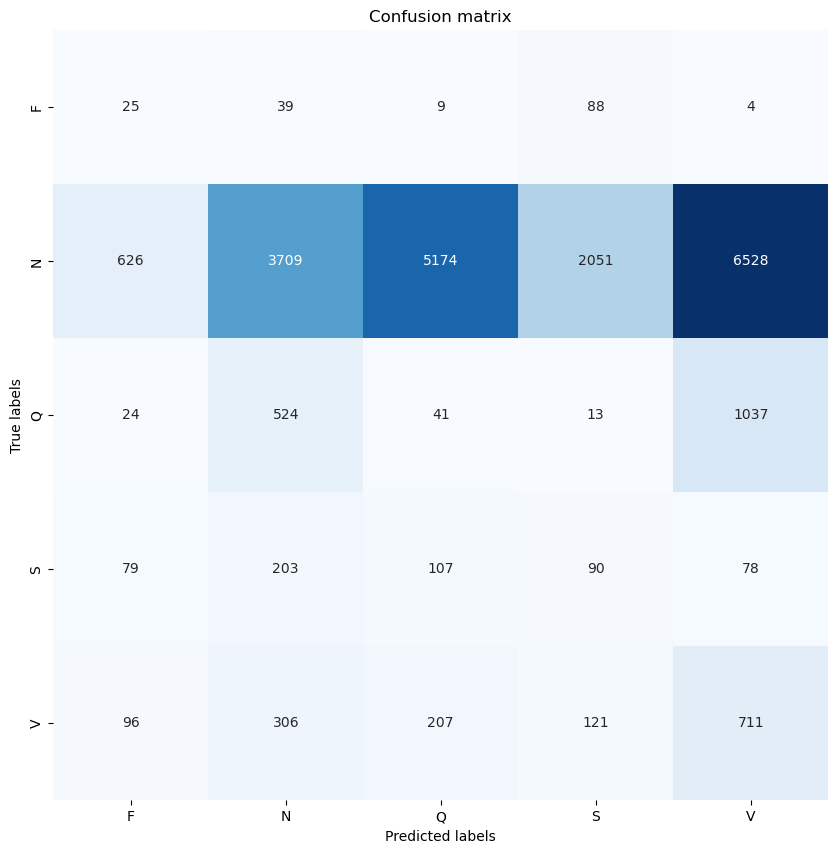

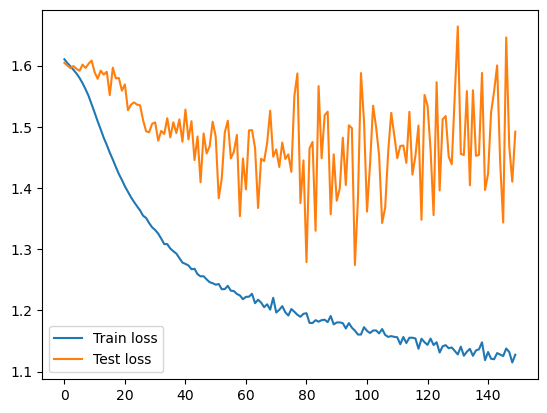

In [67]:
input_dim = train_df.shape[1] - 1
num_classes = len(np.unique(y_train))

# Create and compile the Sequential model
model = keras.Sequential()
model.add(layers.Input(shape=(input_dim,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.fit_transform(test_df[target_column])

# Print the encoding mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Assign X_train and y_train from train_df
X_train = train_df[other_column_names]
y_train = train_df[target_column]

# Assign X_test and y_test from test_df
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Fit the model to your training data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32)  

# Save model
model.save('models/NN.keras')

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall*100:.1f}%')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1*100:.1f}%')

# Calculate Cohen's kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's kappa: {cohen_kappa:.3f}")

# Calculate Matthews corrcoef
matthews = matthews_corrcoef(y_test, y_pred)
print(f"Matthews correlation coefficient: {matthews:.3f}")

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(0.5, num_classes), le.classes_)
plt.yticks(np.arange(0.5, num_classes), le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# Plot train and test loss on the same figure
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Test loss'])
plt.show()

In [68]:
# Print the count of each predicted class
print(pd.Series(y_pred).value_counts())

# Print the count of each actual class
print(pd.Series(y_test).value_counts())

cm = confusion_matrix(y_test, y_pred)
print(cm)

4    8358
2    5538
1    4781
3    2363
0     850
dtype: int64
1    18088
2     1639
4     1441
3      557
0      165
Name: Type, dtype: int64
[[  25   39    9   88    4]
 [ 626 3709 5174 2051 6528]
 [  24  524   41   13 1037]
 [  79  203  107   90   78]
 [  96  306  207  121  711]]


## Unbalanced test_df Convolutional Neural Network

685/685 [==============================] - 2s 2ms/step
Recall: 21.2%
F1 Score: 15.6%
Cohen's kappa: -0.044
Matthews correlation coefficient: -0.060


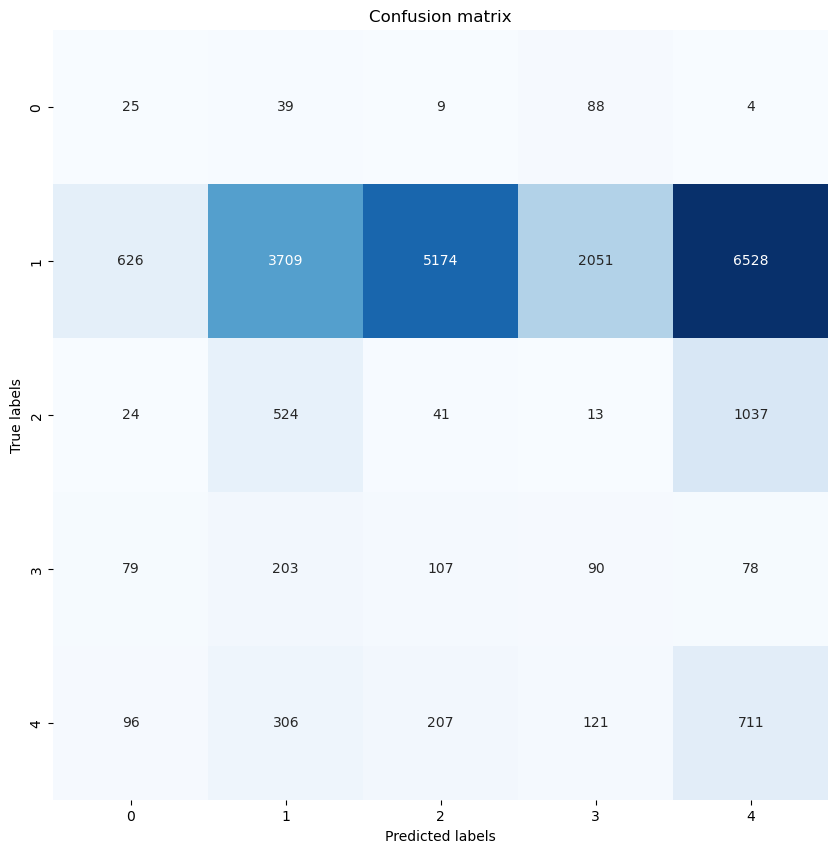

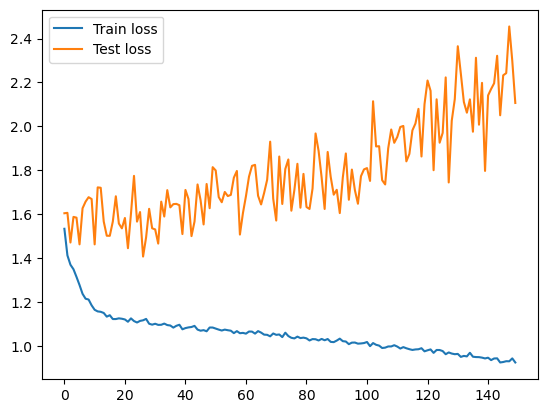

In [69]:
# Read train_df and test_df
train_df = pd.read_csv('dataframes/train_df.csv')
test_df = pd.read_csv('dataframes/test_df.csv')

# Your target column and other column names
target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.transform(test_df[target_column])

# Assign X_train and y_train from train_df
X_train = train_df[other_column_names]
y_train = train_df[target_column]

# Assign X_test and y_test from test_df
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Reshape data for CNN (1D Convolutional Neural Network)
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and compile the CNN model
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model to your training data
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32, verbose=0)

# Save model
model.save('models/CNN.keras')

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall*100:.1f}%')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1*100:.1f}%')

# Calculate Cohen's kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's kappa: {cohen_kappa:.3f}")

# Calculate Matthews corrcoef
matthews = matthews_corrcoef(y_test, y_pred)
print(f"Matthews correlation coefficient: {matthews:.3f}")

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(0.5, len(np.unique(y_test)), 1), le.classes_)
plt.yticks(np.arange(0.5, len(np.unique(y_test)), 1), le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# Plot train and test loss on the same figure
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Test loss'])
plt.show()

## 1 vs all ensemble method

In [7]:
# Read train_df and test_df
train_df = pd.read_csv('dataframes/train_df.csv')
test_df = pd.read_csv('dataframes/test_df.csv')

target_column = 'Type'
other_column_names = [col for col in train_df.columns if col != target_column]

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.fit_transform(test_df[target_column])

X_train = train_df[other_column_names]
y_train = train_df[target_column]
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Define hyperparameters
n_classes = len(np.unique(y_train))
n_base_models = n_classes  # Number of base models, one for each class
n_epochs = 150
batch_size = 32

# Create a list to store base models
base_models = []

# Train a separate model for each class
for class_label in range(n_classes):
    # Create a new model for each class
    model = keras.Sequential()
    model.add(layers.Input(shape=X_train.shape[1]))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

    optimizer = keras.optimizers.SGD(learning_rate=0.01)

    # Compile the model
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['Recall'])

    # If y is equal to class_label, set y_train_binary to 1, otherwise set it to 0
    y_train_binary = np.where(y_train == class_label, 1, 0)
    y_test_binary = np.where(y_test == class_label, 1, 0)

    # Train the model for binary classification
    model.fit(X_train, y_train_binary, epochs=n_epochs, batch_size=batch_size, verbose=0)

    # Append the trained model to the list of base models
    base_models.append(model)

    # Save model
    model.save(f'models/1vsALL_{class_label}.keras')

# Make predictions on the test data using each base model
predictions = np.array([model.predict(X_test) for model in base_models])

# # Select the index of the highest probability from the predictions
ensemble_predictions = np.argmax(predictions, axis=0)

# Evaluate the ensemble's performance
ensemble_recall = recall_score(y_test, ensemble_predictions, average='macro')
print(f"Ensemble Recall: {ensemble_recall*100:.1f}%")
ensemble_f1 = f1_score(y_test, ensemble_predictions, average='macro')
print(f"Ensemble F1 Score: {ensemble_f1*100:.1f}%")
ensemble_cohen_kappa = cohen_kappa_score(y_test, ensemble_predictions)
print(f"Ensemble Cohen's kappa: {ensemble_cohen_kappa:.3f}")
ensemble_matthews_corrcoef = matthews_corrcoef(y_test, ensemble_predictions)
print(f"Ensemble Matthews correlation coefficient: {ensemble_matthews_corrcoef:.3f}")

685/685 [==============================] - 1s 1ms/step
Ensemble Recall: 34.9%
Ensemble F1 Score: 13.1%
Ensemble Cohen's kappa: 0.049
Ensemble Matthews correlation coefficient: 0.094


## Signal Convolutional Neural Network method

In [71]:
# Read raw data dataframe
df = pd.read_csv('dataframes/df.csv')

# Leave only Signal 1, Signal 2, and Type columns
df = df[['Signal 1', 'Signal 2', 'Type']]

C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_1968\2347090460.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataframes/df.csv')


In [72]:
# Group beats with 'Type' value of N, L, R, e and j into the N category
df['Type'].replace(to_replace=['N', 'L', 'R', 'e', 'j'], value='N', inplace=True)

# Group beats with 'Type' value of A, a, J, S into the S category
df['Type'].replace(to_replace=['A', 'a', 'J', 'S'], value='S', inplace=True)

# Group beats with 'Type' value of V, E into the V category
df['Type'].replace(to_replace=['V', 'E'], value='V', inplace=True)

# Group beats with 'Type' value not above (except F) into the Q category
df['Type'].replace(to_replace=['/', 'f', 'Q'], value='Q', inplace=True)

# Eliminate entries with ~, +, x, [, ], !, " and | in 'Type' column
df = df[df['Type'] != '~']
df = df[df['Type'] != '+']
df = df[df['Type'] != 'x']
df = df[df['Type'] != '[']
df = df[df['Type'] != ']']
df = df[df['Type'] != '!']
df = df[df['Type'] != '"']
df = df[df['Type'] != '|']

In [73]:
# Identify the majority class by finding the class with the most samples
majority_class = df['Type'].value_counts().idxmax()

# Separate the majority and minority classes
majority_class_data = df[df['Type'] == majority_class]
minority_class_data = df[df['Type'] != majority_class]

# Determine the number of samples to keep for each minority class
undersampled_minority_class_size = minority_class_data['Type'].value_counts().min()

# Undersample each minority class
undersampled_minority_data = {}
for minority_class in minority_class_data['Type'].unique():
    undersampled_minority_data[minority_class] = minority_class_data[minority_class_data['Type'] == minority_class].sample(n=undersampled_minority_class_size, random_state=42)

# Undersample the majority class
undersampled_majority_data = majority_class_data.sample(n=undersampled_minority_class_size, random_state=42)

# Combine the undersampled minority and majority classes
undersampled_df = pd.concat([undersampled_minority_data[minority_class] for minority_class in undersampled_minority_data], axis=0)
undersampled_df = pd.concat([undersampled_df, undersampled_majority_data])

# Check the counts for each class
print(undersampled_df['Type'].value_counts())

undersampled_df.head()

S    152671
V    152671
Q    152671
F    152671
N    152671
Name: Type, dtype: int64


,Signal 1,Signal 2,Type
29827831,1018.2,989.4,S
29485729,976.8,1038.8,S
15957155,1020.4,993.0,S
19715409,1030.0,1039.8,S
11548567,886.0,934.8,S


In [74]:
# Encode the 'Type' column
le = LabelEncoder()
undersampled_df['Type'] = le.fit_transform(undersampled_df['Type'])

y = undersampled_df['Type']
X = undersampled_df.drop('Type', axis=1)

X = X.values.reshape(X.shape[0], X.shape[1], 1)

# undersampled_df train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

num_classes = len(np.unique(y_train))

model = keras.Sequential()
model.add(layers.Input(shape=(X.shape[1], 1)))
model.add(layers.Conv1D(32, 1, activation='relu'))
model.add(layers.Conv1D(64, 1, activation='relu'))
model.add(layers.Conv1D(128, 1, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Progress monitoring
epochs = 10
batch_size = 64
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Use tqdm for batch processing
    for i in tqdm(range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        model.train_on_batch(X_batch, y_batch)
    
    # Validation at the end of each epoch
    val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the model
model.save('models/Signal_CNN.h5')

# Make predictions on the test data
predictions = model.predict(X_test)

# Select the index of the highest probability from the predictions
predictions = np.argmax(predictions, axis=1)

# Evaluate the model's performance
recall = recall_score(y_test, predictions, average='macro')
print(f"Recall: {recall*100:.1f}%")
f1 = f1_score(y_test, predictions, average='macro')
print(f"F1 Score: {f1*100:.1f}%")
cohen_kappa = cohen_kappa_score(y_test, predictions)
print(f"Cohen's kappa: {cohen_kappa:.3f}")
matthews = matthews_corrcoef(y_test, predictions)
print(f"Matthews correlation coefficient: {matthews:.3f}")

Epoch 1/10


  0%|          | 0/9542 [00:00<?, ?it/s]C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_1968\964242920.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_batch = y_train[i:i + batch_size]
100%|██████████| 9542/9542 [03:42<00:00, 42.95it/s]


Validation Loss: 1.5471, Validation Accuracy: 29.93%
Epoch 2/10


100%|██████████| 9542/9542 [03:37<00:00, 43.86it/s]


Validation Loss: 1.4832, Validation Accuracy: 35.40%
Epoch 3/10


100%|██████████| 9542/9542 [03:36<00:00, 43.99it/s]


Validation Loss: 1.4517, Validation Accuracy: 38.02%
Epoch 4/10


100%|██████████| 9542/9542 [03:37<00:00, 43.84it/s]


Validation Loss: 1.4432, Validation Accuracy: 38.16%
Epoch 5/10


100%|██████████| 9542/9542 [03:37<00:00, 43.91it/s]


Validation Loss: 1.4342, Validation Accuracy: 38.76%
Epoch 6/10


100%|██████████| 9542/9542 [03:38<00:00, 43.74it/s]


Validation Loss: 1.4316, Validation Accuracy: 38.79%
Epoch 7/10


100%|██████████| 9542/9542 [03:37<00:00, 43.90it/s]


Validation Loss: 1.4292, Validation Accuracy: 38.86%
Epoch 8/10


100%|██████████| 9542/9542 [03:37<00:00, 43.92it/s]


Validation Loss: 1.4388, Validation Accuracy: 37.70%
Epoch 9/10


100%|██████████| 9542/9542 [03:37<00:00, 43.95it/s]


Validation Loss: 1.4234, Validation Accuracy: 38.95%
Epoch 10/10


100%|██████████| 9542/9542 [03:36<00:00, 44.16it/s]


Validation Loss: 1.4254, Validation Accuracy: 38.61%
4771/4771 [==============================] - 13s 3ms/step
Recall: 38.7%
F1 Score: 36.8%
Cohen's kappa: 0.233
Matthews correlation coefficient: 0.242


## Grid Search for best Neural Network model

In [56]:
# Read train_df and test_df
train_df = pd.read_csv('dataframes/train_df.csv')
test_df = pd.read_csv('dataframes/test_df.csv')

# Encode the target variable into numerical values
le = LabelEncoder()
train_df['Type'] = le.fit_transform(train_df['Type'])
test_df['Type'] = le.transform(test_df['Type'])

# Define the function to create and compile the model
def create_model(optimizer='adam', num_hidden_layers=3, units_per_layer=64, learning_rate=0.001):
    input_dim = train_df.shape[1] - 1
    num_classes = len(np.unique(train_df['Type']))

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for _ in range(num_hidden_layers):
        model.add(layers.Dense(units_per_layer, activation='relu'))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Set the learning rate for the optimizer
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define hyperparameters for grid search
param_grid = {
    'optimizer': ['adam', 'sgd'],  
    'num_hidden_layers': [2, 3, 4],
    'units_per_layer': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Create the model
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=150, batch_size=32, verbose=0)

# Perform grid search with cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall_macro', cv=kfold)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the best model on the full training data
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro')
print(f'Recall: {recall*100:.1f}%')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1*100:.1f}%')

# Calculate Cohen's kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's kappa: {cohen_kappa:.3f}")

# Calculate Matthews corrcoef
matthews = matthews_corrcoef(y_test, y_pred)
print(f"Matthews correlation coefficient: {matthews:.3f}")

20/20 [==============================] - 0s 2ms/step
Best: 0.581683 using {'learning_rate': 0.01, 'num_hidden_layers': 4, 'optimizer': 'sgd', 'units_per_layer': 128}
0.569761 (0.010829) with: {'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units_per_layer': 32}
0.565039 (0.012991) with: {'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units_per_layer': 64}
0.564419 (0.022385) with: {'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'adam', 'units_per_layer': 128}
0.564751 (0.014657) with: {'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'sgd', 'units_per_layer': 32}
0.570406 (0.018828) with: {'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'sgd', 'units_per_layer': 64}
0.560677 (0.022611) with: {'learning_rate': 0.001, 'num_hidden_layers': 2, 'optimizer': 'sgd', 'units_per_layer': 128}
0.561587 (0.018613) with: {'learning_rate': 0.001, 'num_hidden_layers': 3, 'optimizer': 'adam', 'units_per_layer': 32}
0.

In [57]:
print(grid.best_params_)

{'learning_rate': 0.01, 'num_hidden_layers': 4, 'optimizer': 'sgd', 'units_per_layer': 128}
